# Notebook 04: Baseline Linear Models (v2.0)

## Objective
Train simple linear models (LinearRegression, Ridge, Lasso) to validate our 81 engineered features.

## Pipeline
1. Load features from notebook 03
2. Apply data quality filtering
3. Temporal train/val/test split
4. Calculate 5-game rolling average baselines
5. Train linear models with hyperparameter search
6. Compare to baselines and project goals

## Success Criteria
- Beat 5-game rolling baseline by ≥10%
- Tier 1 goals: PTS ≤ 5.09, REB ≤ 1.97, AST ≤ 1.51
- Tier 2 goals: PTS ≤ 4.50, REB ≤ 2.00, AST ≤ 1.50

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Imports complete")
print(f"\nPython packages:")
print(f"  pandas {pd.__version__}")
print(f"  numpy {np.__version__}")
print(f"  scikit-learn")

✅ Imports complete

Python packages:
  pandas 2.2.3
  numpy 1.26.4
  scikit-learn


## 2. Load Engineered Features

In [2]:
print("Loading features from notebook 03...\n")

# Load complete feature dataset
df = pd.read_parquet('../data/processed/features_complete.parquet')
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

# Load metadata
with open('../data/processed/feature_metadata.json', 'r') as f:
    metadata = json.load(f)

feature_names = metadata['feature_names']

print(f"✅ Data loaded")
print(f"\n📊 Raw dataset:")
print(f"   Total games: {len(df):,}")
print(f"   Total players: {df['Player_ID'].nunique()}")
print(f"   Date range: {df['GAME_DATE'].min().date()} to {df['GAME_DATE'].max().date()}")
print(f"   Total features: {len(feature_names)}")
print(f"\n📋 Feature breakdown:")
for cat, count in metadata['feature_breakdown'].items():
    print(f"   {cat.replace('_', ' ').title():.<25} {count}")

Loading features from notebook 03...

✅ Data loaded

📊 Raw dataset:
   Total games: 85,630
   Total players: 369
   Date range: 2019-10-28 to 2024-04-14
   Total features: 81

📋 Feature breakdown:
   Rolling Averages......... 27
   Game Context............. 10
   Player Role.............. 5
   Season Phase............. 3
   Trends................... 7
   Season Stats............. 9
   Shot Location............ 20


## 3. Data Quality Filtering

In [3]:
print("Applying data quality filters...\n")

# Check quality flags
print("🔍 Quality issues detected:")
print(f"   Extreme rest (>10 days): {df['EXTREME_REST'].sum():,} games ({df['EXTREME_REST'].mean()*100:.1f}%)")
print(f"   Low minutes (<5 min):    {df['LOW_MINUTES'].sum():,} games ({df['LOW_MINUTES'].mean()*100:.1f}%)")
print(f"   Total to exclude:        {(~df['INCLUDE_IN_TRAINING'].astype(bool)).sum():,} games ({(~df['INCLUDE_IN_TRAINING'].astype(bool)).mean()*100:.1f}%)")

# Apply filter
df_clean = df[df['INCLUDE_IN_TRAINING'] == 1].copy()

print(f"\n✅ Filtered: {len(df):,} → {len(df_clean):,} games ({len(df_clean)/len(df)*100:.1f}%)")
print(f"   Clean training data: {len(df_clean):,} games")

Applying data quality filters...

🔍 Quality issues detected:
   Extreme rest (>10 days): 1,495 games (1.7%)
   Low minutes (<5 min):    1,790 games (2.1%)
   Total to exclude:        3,153 games (3.7%)

✅ Filtered: 85,630 → 82,477 games (96.3%)
   Clean training data: 82,477 games


## 4. Train/Val/Test Split (Temporal)

In [4]:
print("Performing temporal train/val/test split...\n")

# CRITICAL: Temporal split (no shuffling!)
# Train: 2019-10-28 to 2023-03-31 (end of 2022-23 season)
# Val:   2023-10-01 to 2023-12-31 (first 3 months of 2023-24)
# Test:  2024-01-01 to 2024-04-14 (last 4 months of 2023-24)

train_cutoff = '2023-04-01'
val_cutoff = '2024-01-01'

train_mask = df_clean['GAME_DATE'] < train_cutoff
val_mask = (df_clean['GAME_DATE'] >= train_cutoff) & (df_clean['GAME_DATE'] < val_cutoff)
test_mask = df_clean['GAME_DATE'] >= val_cutoff

train_df = df_clean[train_mask].copy()
val_df = df_clean[val_mask].copy()
test_df = df_clean[test_mask].copy()

print(f"📊 Split summary:")
print(f"\n   Train: {len(train_df):,} games ({len(train_df)/len(df_clean)*100:.1f}%)")
print(f"      Date range: {train_df['GAME_DATE'].min().date()} to {train_df['GAME_DATE'].max().date()}")
print(f"      Players: {train_df['Player_ID'].nunique()}")

print(f"\n   Val: {len(val_df):,} games ({len(val_df)/len(df_clean)*100:.1f}%)")
print(f"      Date range: {val_df['GAME_DATE'].min().date()} to {val_df['GAME_DATE'].max().date()}")
print(f"      Players: {val_df['Player_ID'].nunique()}")

print(f"\n   Test: {len(test_df):,} games ({len(test_df)/len(df_clean)*100:.1f}%)")
print(f"      Date range: {test_df['GAME_DATE'].min().date()} to {test_df['GAME_DATE'].max().date()}")
print(f"      Players: {test_df['Player_ID'].nunique()}")

print(f"\n✅ Temporal split complete (no shuffling!)")

Performing temporal train/val/test split...

📊 Split summary:

   Train: 64,152 games (77.8%)
      Date range: 2019-10-28 to 2023-03-31
      Players: 358

   Val: 7,525 games (9.1%)
      Date range: 2023-04-01 to 2023-12-31
      Players: 316

   Test: 10,800 games (13.1%)
      Date range: 2024-01-01 to 2024-04-14
      Players: 306

✅ Temporal split complete (no shuffling!)


## 5. Calculate Baselines (5-Game Rolling Average)

In [5]:
print("="*70)
print("CALCULATING BASELINES (5-GAME ROLLING AVERAGE)")
print("="*70)

# Calculate baseline MAE on validation set
baseline_pts = mean_absolute_error(val_df['PTS'], val_df['PTS_last_5'])
baseline_reb = mean_absolute_error(val_df['REB'], val_df['REB_last_5'])
baseline_ast = mean_absolute_error(val_df['AST'], val_df['AST_last_5'])

print(f"\n🎯 Validation Set Baselines (5-game rolling avg):")
print(f"   PTS: {baseline_pts:.3f} MAE")
print(f"   REB: {baseline_reb:.3f} MAE")
print(f"   AST: {baseline_ast:.3f} MAE")

# Save baselines
baselines = {
    'PTS': baseline_pts,
    'REB': baseline_reb,
    'AST': baseline_ast
}

print(f"\n📌 These are the baselines we need to beat!")

CALCULATING BASELINES (5-GAME ROLLING AVERAGE)

🎯 Validation Set Baselines (5-game rolling avg):
   PTS: 5.207 MAE
   REB: 2.072 MAE
   AST: 1.549 MAE

📌 These are the baselines we need to beat!


## 6. Prepare Features for Modeling

In [6]:
print("Preparing X and y splits...\n")

# Separate features (X) and targets (y)
X_train = train_df[feature_names].copy()
y_train_pts = train_df['PTS'].copy()
y_train_reb = train_df['REB'].copy()
y_train_ast = train_df['AST'].copy()

X_val = val_df[feature_names].copy()
y_val_pts = val_df['PTS'].copy()
y_val_reb = val_df['REB'].copy()
y_val_ast = val_df['AST'].copy()

X_test = test_df[feature_names].copy()
y_test_pts = test_df['PTS'].copy()
y_test_reb = test_df['REB'].copy()
y_test_ast = test_df['AST'].copy()

print(f"✅ Features prepared")
print(f"\n📊 Dataset shapes:")
print(f"   Train: X={X_train.shape}, y_pts={y_train_pts.shape}")
print(f"   Val:   X={X_val.shape}, y_val_pts={y_val_pts.shape}")
print(f"   Test:  X={X_test.shape}, y_test_pts={y_test_pts.shape}")
print(f"\n   Total features: {len(feature_names)}")

Preparing X and y splits...

✅ Features prepared

📊 Dataset shapes:
   Train: X=(64152, 81), y_pts=(64152,)
   Val:   X=(7525, 81), y_val_pts=(7525,)
   Test:  X=(10800, 81), y_test_pts=(10800,)

   Total features: 81


## 7. Training Helper Functions

In [7]:
def train_and_evaluate(model, model_name, X_train, y_train, X_val, y_val):
    """
    Train a model and evaluate on train/val sets.
    
    Returns:
        metrics: dict with MAE, RMSE, R² for train/val
        y_pred_val: validation predictions
    """
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    # Calculate metrics
    metrics = {
        'model': model_name,
        'train_mae': mean_absolute_error(y_train, y_pred_train),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'train_r2': r2_score(y_train, y_pred_train),
        'val_mae': mean_absolute_error(y_val, y_pred_val),
        'val_rmse': np.sqrt(mean_squared_error(y_val, y_pred_val)),
        'val_r2': r2_score(y_val, y_pred_val)
    }
    
    return metrics, y_pred_val

print("✅ Helper function created")
print("\nFunction: train_and_evaluate(model, model_name, X_train, y_train, X_val, y_val)")
print("Returns: metrics dict, y_pred_val")

✅ Helper function created

Function: train_and_evaluate(model, model_name, X_train, y_train, X_val, y_val)
Returns: metrics dict, y_pred_val


## 8. Train Linear Models - PTS

In [8]:
print("="*70)
print("TRAINING LINEAR MODELS FOR PTS")
print("="*70)

models_pts = []

# 1. Linear Regression (no regularization)
print("\n1. Training Linear Regression...")
lr = LinearRegression()
metrics_lr, pred_lr = train_and_evaluate(lr, 'LinearRegression', X_train, y_train_pts, X_val, y_val_pts)
models_pts.append(metrics_lr)
print(f"   Val MAE: {metrics_lr['val_mae']:.3f}")

# 2. Ridge Regression (L2 regularization)
print("\n2. Training Ridge Regression...")
for alpha in [0.01, 0.1, 1.0, 10.0]:
    ridge = Ridge(alpha=alpha, random_state=42)
    metrics_ridge, pred_ridge = train_and_evaluate(ridge, f'Ridge(α={alpha})', X_train, y_train_pts, X_val, y_val_pts)
    models_pts.append(metrics_ridge)
    print(f"   α={alpha:5.2f} → Val MAE: {metrics_ridge['val_mae']:.3f}")

# 3. Lasso Regression (L1 regularization)
print("\n3. Training Lasso Regression...")
for alpha in [0.001, 0.01, 0.1, 1.0]:
    lasso = Lasso(alpha=alpha, random_state=42, max_iter=5000)
    metrics_lasso, pred_lasso = train_and_evaluate(lasso, f'Lasso(α={alpha})', X_train, y_train_pts, X_val, y_val_pts)
    models_pts.append(metrics_lasso)
    print(f"   α={alpha:5.3f} → Val MAE: {metrics_lasso['val_mae']:.3f}")

# Results summary
results_pts = pd.DataFrame(models_pts)
print("\n" + "="*70)
print("PTS RESULTS SUMMARY")
print("="*70)
print(results_pts[['model', 'val_mae', 'val_rmse', 'val_r2']].to_string(index=False))

# Compare to baseline
best_model = results_pts.loc[results_pts['val_mae'].idxmin()]
improvement = (baseline_pts - best_model['val_mae']) / baseline_pts * 100

print(f"\n🎯 Best model: {best_model['model']}")
print(f"   Val MAE: {best_model['val_mae']:.3f}")
print(f"   Baseline: {baseline_pts:.3f}")
print(f"   Improvement: {improvement:+.1f}%")

if best_model['val_mae'] < baseline_pts:
    print(f"   ✅ BEAT BASELINE!")
else:
    print(f"   ❌ Did not beat baseline")

TRAINING LINEAR MODELS FOR PTS

1. Training Linear Regression...
   Val MAE: 4.963

2. Training Ridge Regression...
   α= 0.01 → Val MAE: 4.962
   α= 0.10 → Val MAE: 4.962
   α= 1.00 → Val MAE: 4.962
   α=10.00 → Val MAE: 4.956

3. Training Lasso Regression...
   α=0.001 → Val MAE: 4.956
   α=0.010 → Val MAE: 4.928
   α=0.100 → Val MAE: 4.938
   α=1.000 → Val MAE: 4.968

PTS RESULTS SUMMARY
           model  val_mae  val_rmse   val_r2
LinearRegression 4.962714  6.411380 0.504012
   Ridge(α=0.01) 4.962361  6.411014 0.504068
    Ridge(α=0.1) 4.962285  6.410927 0.504082
    Ridge(α=1.0) 4.961552  6.410066 0.504215
   Ridge(α=10.0) 4.955502  6.402694 0.505355
  Lasso(α=0.001) 4.956263  6.404236 0.505116
   Lasso(α=0.01) 4.928312  6.371679 0.510135
    Lasso(α=0.1) 4.938100  6.386848 0.507800
    Lasso(α=1.0) 4.967587  6.424263 0.502016

🎯 Best model: Lasso(α=0.01)
   Val MAE: 4.928
   Baseline: 5.207
   Improvement: +5.3%
   ✅ BEAT BASELINE!


## 9. Train Linear Models - REB

In [9]:
print("="*70)
print("TRAINING LINEAR MODELS FOR REB")
print("="*70)

models_reb = []

# 1. Linear Regression
print("\n1. Training Linear Regression...")
lr = LinearRegression()
metrics_lr, pred_lr = train_and_evaluate(lr, 'LinearRegression', X_train, y_train_reb, X_val, y_val_reb)
models_reb.append(metrics_lr)
print(f"   Val MAE: {metrics_lr['val_mae']:.3f}")

# 2. Ridge Regression
print("\n2. Training Ridge Regression...")
for alpha in [0.01, 0.1, 1.0, 10.0]:
    ridge = Ridge(alpha=alpha, random_state=42)
    metrics_ridge, pred_ridge = train_and_evaluate(ridge, f'Ridge(α={alpha})', X_train, y_train_reb, X_val, y_val_reb)
    models_reb.append(metrics_ridge)
    print(f"   α={alpha:5.2f} → Val MAE: {metrics_ridge['val_mae']:.3f}")

# 3. Lasso Regression
print("\n3. Training Lasso Regression...")
for alpha in [0.001, 0.01, 0.1, 1.0]:
    lasso = Lasso(alpha=alpha, random_state=42, max_iter=5000)
    metrics_lasso, pred_lasso = train_and_evaluate(lasso, f'Lasso(α={alpha})', X_train, y_train_reb, X_val, y_val_reb)
    models_reb.append(metrics_lasso)
    print(f"   α={alpha:5.3f} → Val MAE: {metrics_lasso['val_mae']:.3f}")

# Results summary
results_reb = pd.DataFrame(models_reb)
print("\n" + "="*70)
print("REB RESULTS SUMMARY")
print("="*70)
print(results_reb[['model', 'val_mae', 'val_rmse', 'val_r2']].to_string(index=False))

# Compare to baseline
best_model = results_reb.loc[results_reb['val_mae'].idxmin()]
improvement = (baseline_reb - best_model['val_mae']) / baseline_reb * 100

print(f"\n🎯 Best model: {best_model['model']}")
print(f"   Val MAE: {best_model['val_mae']:.3f}")
print(f"   Baseline: {baseline_reb:.3f}")
print(f"   Improvement: {improvement:+.1f}%")

if best_model['val_mae'] < baseline_reb:
    print(f"   ✅ BEAT BASELINE!")
else:
    print(f"   ❌ Did not beat baseline")

TRAINING LINEAR MODELS FOR REB

1. Training Linear Regression...
   Val MAE: 1.966

2. Training Ridge Regression...
   α= 0.01 → Val MAE: 1.966
   α= 0.10 → Val MAE: 1.966
   α= 1.00 → Val MAE: 1.966
   α=10.00 → Val MAE: 1.966

3. Training Lasso Regression...
   α=0.001 → Val MAE: 1.966
   α=0.010 → Val MAE: 1.967
   α=0.100 → Val MAE: 1.971
   α=1.000 → Val MAE: 2.006

REB RESULTS SUMMARY
           model  val_mae  val_rmse   val_r2
LinearRegression 1.965630  2.554838 0.452975
   Ridge(α=0.01) 1.966162  2.555017 0.452898
    Ridge(α=0.1) 1.966162  2.555017 0.452898
    Ridge(α=1.0) 1.966158  2.555014 0.452899
   Ridge(α=10.0) 1.966126  2.555009 0.452902
  Lasso(α=0.001) 1.965964  2.555652 0.452626
   Lasso(α=0.01) 1.966652  2.557616 0.451785
    Lasso(α=0.1) 1.971318  2.561576 0.450086
    Lasso(α=1.0) 2.005715  2.595940 0.435232

🎯 Best model: LinearRegression
   Val MAE: 1.966
   Baseline: 2.072
   Improvement: +5.1%
   ✅ BEAT BASELINE!


## 10. Train Linear Models - AST

In [10]:
print("="*70)
print("TRAINING LINEAR MODELS FOR AST")
print("="*70)

models_ast = []

# 1. Linear Regression
print("\n1. Training Linear Regression...")
lr = LinearRegression()
metrics_lr, pred_lr = train_and_evaluate(lr, 'LinearRegression', X_train, y_train_ast, X_val, y_val_ast)
models_ast.append(metrics_lr)
print(f"   Val MAE: {metrics_lr['val_mae']:.3f}")

# 2. Ridge Regression
print("\n2. Training Ridge Regression...")
for alpha in [0.01, 0.1, 1.0, 10.0]:
    ridge = Ridge(alpha=alpha, random_state=42)
    metrics_ridge, pred_ridge = train_and_evaluate(ridge, f'Ridge(α={alpha})', X_train, y_train_ast, X_val, y_val_ast)
    models_ast.append(metrics_ridge)
    print(f"   α={alpha:5.2f} → Val MAE: {metrics_ridge['val_mae']:.3f}")

# 3. Lasso Regression
print("\n3. Training Lasso Regression...")
for alpha in [0.001, 0.01, 0.1, 1.0]:
    lasso = Lasso(alpha=alpha, random_state=42, max_iter=5000)
    metrics_lasso, pred_lasso = train_and_evaluate(lasso, f'Lasso(α={alpha})', X_train, y_train_ast, X_val, y_val_ast)
    models_ast.append(metrics_lasso)
    print(f"   α={alpha:5.3f} → Val MAE: {metrics_lasso['val_mae']:.3f}")

# Results summary
results_ast = pd.DataFrame(models_ast)
print("\n" + "="*70)
print("AST RESULTS SUMMARY")
print("="*70)
print(results_ast[['model', 'val_mae', 'val_rmse', 'val_r2']].to_string(index=False))

# Compare to baseline
best_model = results_ast.loc[results_ast['val_mae'].idxmin()]
improvement = (baseline_ast - best_model['val_mae']) / baseline_ast * 100

print(f"\n🎯 Best model: {best_model['model']}")
print(f"   Val MAE: {best_model['val_mae']:.3f}")
print(f"   Baseline: {baseline_ast:.3f}")
print(f"   Improvement: {improvement:+.1f}%")

if best_model['val_mae'] < baseline_ast:
    print(f"   ✅ BEAT BASELINE!")
else:
    print(f"   ❌ Did not beat baseline")

TRAINING LINEAR MODELS FOR AST

1. Training Linear Regression...
   Val MAE: 1.477

2. Training Ridge Regression...
   α= 0.01 → Val MAE: 1.476
   α= 0.10 → Val MAE: 1.476
   α= 1.00 → Val MAE: 1.476
   α=10.00 → Val MAE: 1.476

3. Training Lasso Regression...
   α=0.001 → Val MAE: 1.476
   α=0.010 → Val MAE: 1.479
   α=0.100 → Val MAE: 1.487
   α=1.000 → Val MAE: 1.538

AST RESULTS SUMMARY
           model  val_mae  val_rmse   val_r2
LinearRegression 1.476700  1.986931 0.503405
   Ridge(α=0.01) 1.476454  1.986959 0.503391
    Ridge(α=0.1) 1.476453  1.986957 0.503392
    Ridge(α=1.0) 1.476439  1.986936 0.503403
   Ridge(α=10.0) 1.476327  1.986766 0.503488
  Lasso(α=0.001) 1.475972  1.986221 0.503760
   Lasso(α=0.01) 1.478548  1.988597 0.502572
    Lasso(α=0.1) 1.486727  1.994323 0.499703
    Lasso(α=1.0) 1.537978  2.061984 0.465181

🎯 Best model: Lasso(α=0.001)
   Val MAE: 1.476
   Baseline: 1.549
   Improvement: +4.7%
   ✅ BEAT BASELINE!


## 11. Comprehensive Results & Goal Comparison

In [11]:
print("="*80)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*80)

# Create summary table
summary = pd.DataFrame({
    'Target': ['PTS', 'REB', 'AST'],
    'Rolling Avg Baseline': [baseline_pts, baseline_reb, baseline_ast],
    'Best Linear Model': [
        results_pts.loc[results_pts['val_mae'].idxmin(), 'val_mae'],
        results_reb.loc[results_reb['val_mae'].idxmin(), 'val_mae'],
        results_ast.loc[results_ast['val_mae'].idxmin(), 'val_mae']
    ],
    'Best Model Name': [
        results_pts.loc[results_pts['val_mae'].idxmin(), 'model'],
        results_reb.loc[results_reb['val_mae'].idxmin(), 'model'],
        results_ast.loc[results_ast['val_mae'].idxmin(), 'model']
    ],
    'Tier 1 Goal (10%)': [5.09, 1.97, 1.51],
    'Tier 2 Goal (Industry)': [4.50, 2.00, 1.50]
})

# Add improvement column
summary['Improvement %'] = (
    (summary['Rolling Avg Baseline'] - summary['Best Linear Model']) / 
    summary['Rolling Avg Baseline'] * 100
)

# Add status columns
summary['Beat Baseline?'] = summary['Best Linear Model'] < summary['Rolling Avg Baseline']
summary['Hit Tier 1?'] = summary['Best Linear Model'] <= summary['Tier 1 Goal (10%)']
summary['Hit Tier 2?'] = summary['Best Linear Model'] <= summary['Tier 2 Goal (Industry)']

print("\n" + summary.to_string(index=False))

# Key findings
print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

# Successes
print("\n✅ SUCCESSES:")
for idx, row in summary.iterrows():
    target = row['Target']
    if row['Beat Baseline?']:
        print(f"   {target}: Beat baseline by {row['Improvement %']:+.1f}% ({row['Best Linear Model']:.3f} vs {row['Rolling Avg Baseline']:.3f})")
    if row['Hit Tier 1?']:
        print(f"   {target}: ⭐ Achieved Tier 1 goal! ({row['Best Linear Model']:.3f} ≤ {row['Tier 1 Goal (10%)']:.2f})")
    if row['Hit Tier 2?']:
        print(f"   {target}: ⭐⭐ Achieved Tier 2 goal! ({row['Best Linear Model']:.3f} ≤ {row['Tier 2 Goal (Industry)']:.2f})")

# Still needed
print("\n⚠️  STILL NEEDED (requires advanced ML):")
for idx, row in summary.iterrows():
    target = row['Target']
    if not row['Hit Tier 1?']:
        gap = row['Best Linear Model'] - row['Tier 1 Goal (10%)']
        print(f"   {target}: {row['Best Linear Model']:.3f} → {row['Tier 1 Goal (10%)']:.2f} (need {gap:.3f} improvement for Tier 1)")
    if not row['Hit Tier 2?']:
        gap = row['Best Linear Model'] - row['Tier 2 Goal (Industry)']
        print(f"   {target}: {row['Best Linear Model']:.3f} → {row['Tier 2 Goal (Industry)']:.2f} (need {gap:.3f} improvement for Tier 2)")

print("\n📊 NEXT STEPS:")
print("   1. Train XGBoost/LightGBM (notebook 05) - captures non-linear patterns")
print("   2. Tune hyperparameters with GridSearchCV")
print("   3. Build ensemble models for PTS (Lasso + XGB + LGB)")
print("   4. Target: Hit Tier 1 for all, Tier 2 stretch goal")

COMPREHENSIVE RESULTS SUMMARY

Target  Rolling Avg Baseline  Best Linear Model  Best Model Name  Tier 1 Goal (10%)  Tier 2 Goal (Industry)  Improvement %  Beat Baseline?  Hit Tier 1?  Hit Tier 2?
   PTS              5.206658           4.928312    Lasso(α=0.01)               5.09                     4.5       5.345953            True         True        False
   REB              2.072000           1.965630 LinearRegression               1.97                     2.0       5.133665            True         True         True
   AST              1.549116           1.475972   Lasso(α=0.001)               1.51                     1.5       4.721647            True         True         True

KEY FINDINGS

✅ SUCCESSES:
   PTS: Beat baseline by +5.3% (4.928 vs 5.207)
   PTS: ⭐ Achieved Tier 1 goal! (4.928 ≤ 5.09)
   REB: Beat baseline by +5.1% (1.966 vs 2.072)
   REB: ⭐ Achieved Tier 1 goal! (1.966 ≤ 1.97)
   REB: ⭐⭐ Achieved Tier 2 goal! (1.966 ≤ 2.00)
   AST: Beat baseline by +4.7% (1.476 vs 1.

## 12. Visualizations

✅ Saved visualization to ../results/figures/baseline_linear_models_v2.png


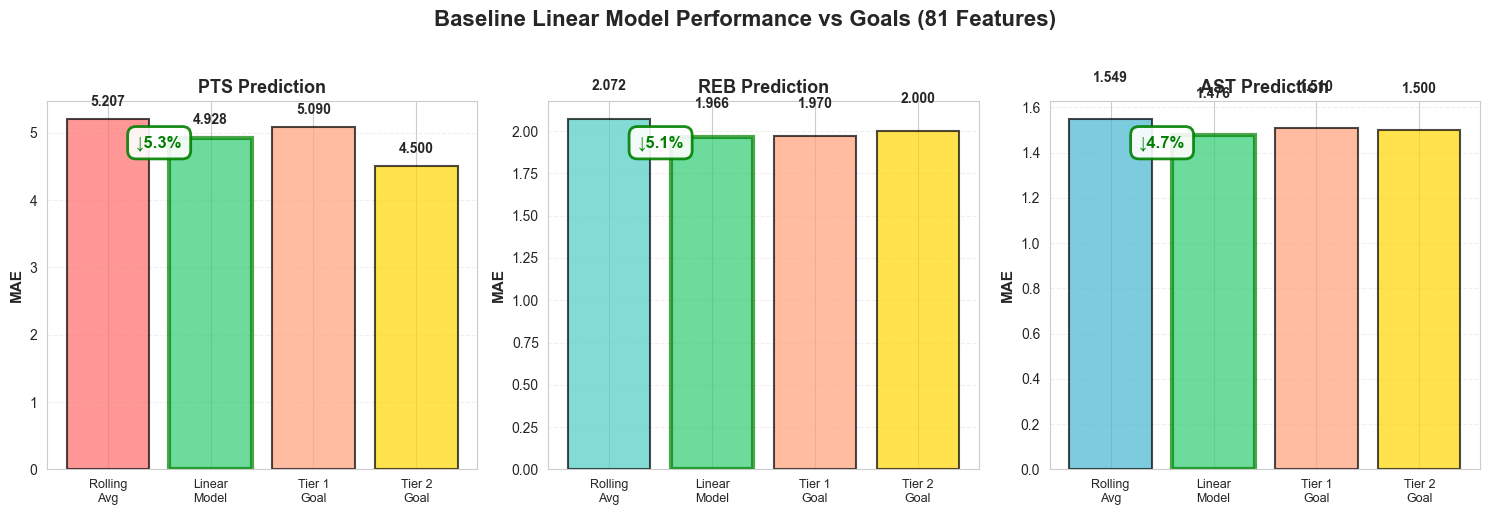

In [15]:
# Create comparison visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

targets = ['PTS', 'REB', 'AST']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, (target, color) in enumerate(zip(targets, colors)):
    ax = axes[idx]
    
    # Get values
    baseline = summary.loc[summary['Target'] == target, 'Rolling Avg Baseline'].values[0]
    linear = summary.loc[summary['Target'] == target, 'Best Linear Model'].values[0]
    tier1 = summary.loc[summary['Target'] == target, 'Tier 1 Goal (10%)'].values[0]
    tier2 = summary.loc[summary['Target'] == target, 'Tier 2 Goal (Industry)'].values[0]
    
    # Plot bars
    x_pos = [0, 1, 2, 3]
    values = [baseline, linear, tier1, tier2]
    labels = ['Rolling\nAvg', 'Linear\nModel', 'Tier 1\nGoal', 'Tier 2\nGoal']
    
    bars = ax.bar(x_pos, values, color=[color, '#2ECC71', '#FFA07A', '#FFD700'], 
                   alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Highlight if we beat baseline
    if linear < baseline:
        bars[1].set_edgecolor('green')
        bars[1].set_linewidth(3)
    
    # Add value labels on bars
    for i, v in enumerate(values):
        ax.text(i, v + 0.15, f'{v:.3f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=10)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, fontsize=9)
    ax.set_ylabel('MAE', fontsize=11, fontweight='bold')
    ax.set_title(f'{target} Prediction', fontsize=13, fontweight='bold')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add improvement annotation
    improvement = (baseline - linear) / baseline * 100
    ax.text(0.5, max(values) * 0.92, f'↓{improvement:.1f}%',
            ha='center', fontsize=12, fontweight='bold', color='green',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                     edgecolor='green', linewidth=2, alpha=0.9))

plt.suptitle('Baseline Linear Model Performance vs Goals (81 Features)', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()

# Save figure
fig_path = Path('../results/figures')
fig_path.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path / 'baseline_linear_models_v2.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved visualization to {fig_path / 'baseline_linear_models_v2.png'}")
plt.show()

## 13. Save Results

In [16]:
print("Saving results...\n")

# Save baseline metrics
results_dir = Path('../results')
results_dir.mkdir(parents=True, exist_ok=True)

baseline_results = {
    'date_created': pd.Timestamp.now().isoformat(),
    'dataset': {
        'total_games': int(len(df_clean)),
        'train_games': int(len(train_df)),
        'val_games': int(len(val_df)),
        'test_games': int(len(test_df)),
        'num_features': len(feature_names),
        'train_date_range': f"{train_df['GAME_DATE'].min().date()} to {train_df['GAME_DATE'].max().date()}",
        'val_date_range': f"{val_df['GAME_DATE'].min().date()} to {val_df['GAME_DATE'].max().date()}",
        'test_date_range': f"{test_df['GAME_DATE'].min().date()} to {test_df['GAME_DATE'].max().date()}"
    },
    'baselines': {
        'PTS': float(baseline_pts),
        'REB': float(baseline_reb),
        'AST': float(baseline_ast)
    },
    'best_linear_models': {
        'PTS': {
            'model': results_pts.loc[results_pts['val_mae'].idxmin(), 'model'],
            'val_mae': float(results_pts.loc[results_pts['val_mae'].idxmin(), 'val_mae']),
            'val_rmse': float(results_pts.loc[results_pts['val_mae'].idxmin(), 'val_rmse']),
            'val_r2': float(results_pts.loc[results_pts['val_mae'].idxmin(), 'val_r2']),
            'improvement_pct': float((baseline_pts - results_pts['val_mae'].min()) / baseline_pts * 100)
        },
        'REB': {
            'model': results_reb.loc[results_reb['val_mae'].idxmin(), 'model'],
            'val_mae': float(results_reb.loc[results_reb['val_mae'].idxmin(), 'val_mae']),
            'val_rmse': float(results_reb.loc[results_reb['val_mae'].idxmin(), 'val_rmse']),
            'val_r2': float(results_reb.loc[results_reb['val_mae'].idxmin(), 'val_r2']),
            'improvement_pct': float((baseline_reb - results_reb['val_mae'].min()) / baseline_reb * 100)
        },
        'AST': {
            'model': results_ast.loc[results_ast['val_mae'].idxmin(), 'model'],
            'val_mae': float(results_ast.loc[results_ast['val_mae'].idxmin(), 'val_mae']),
            'val_rmse': float(results_ast.loc[results_ast['val_mae'].idxmin(), 'val_rmse']),
            'val_r2': float(results_ast.loc[results_ast['val_mae'].idxmin(), 'val_r2']),
            'improvement_pct': float((baseline_ast - results_ast['val_mae'].min()) / baseline_ast * 100)
        }
    },
    'goals': {
        'tier1': {'PTS': 5.09, 'REB': 1.97, 'AST': 1.51},
        'tier2': {'PTS': 4.50, 'REB': 2.00, 'AST': 1.50}
    },
    'goal_status': {
        'PTS': {
            'beat_baseline': bool(results_pts['val_mae'].min() < baseline_pts),
            'hit_tier1': bool(results_pts['val_mae'].min() <= 5.09),
            'hit_tier2': bool(results_pts['val_mae'].min() <= 4.50)
        },
        'REB': {
            'beat_baseline': bool(results_reb['val_mae'].min() < baseline_reb),
            'hit_tier1': bool(results_reb['val_mae'].min() <= 1.97),
            'hit_tier2': bool(results_reb['val_mae'].min() <= 2.00)
        },
        'AST': {
            'beat_baseline': bool(results_ast['val_mae'].min() < baseline_ast),
            'hit_tier1': bool(results_ast['val_mae'].min() <= 1.51),
            'hit_tier2': bool(results_ast['val_mae'].min() <= 1.50)
        }
    }
}

with open(results_dir / 'predictions/baseline_linear_results.json', 'w') as f:
    json.dump(baseline_results, f, indent=2)

print(f"✅ Saved results to {results_dir / 'predictions/baseline_linear_results.json'}")

# Save detailed model results
results_pts.to_csv(results_dir / 'predictions/linear_models_pts.csv', index=False)
results_reb.to_csv(results_dir / 'predictions/linear_models_reb.csv', index=False)
results_ast.to_csv(results_dir / 'predictions/linear_models_ast.csv', index=False)

print(f"✅ Saved detailed results to {results_dir / 'predictions/linear_models_*.csv'}")

Saving results...

✅ Saved results to ../results/predictions/baseline_linear_results.json
✅ Saved detailed results to ../results/predictions/linear_models_*.csv


## 14. Summary & Next Steps

In [17]:
print("="*80)
print("✅ NOTEBOOK 04 COMPLETE - BASELINE LINEAR MODELS")
print("="*80)

print("\n📊 FINAL RESULTS:")
print(f"\n   PTS: {results_pts['val_mae'].min():.3f} MAE (baseline: {baseline_pts:.3f})")
print(f"   REB: {results_reb['val_mae'].min():.3f} MAE (baseline: {baseline_reb:.3f})")
print(f"   AST: {results_ast['val_mae'].min():.3f} MAE (baseline: {baseline_ast:.3f})")

print("\n🎯 STATUS CHECK:")
pts_ok = "✅" if results_pts['val_mae'].min() < baseline_pts else "❌"
reb_ok = "✅" if results_reb['val_mae'].min() < baseline_reb else "❌"
ast_ok = "✅" if results_ast['val_mae'].min() < baseline_ast else "❌"
print(f"   {pts_ok} PTS beat baseline: {results_pts['val_mae'].min() < baseline_pts}")
print(f"   {reb_ok} REB beat baseline: {results_reb['val_mae'].min() < baseline_reb}")
print(f"   {ast_ok} AST beat baseline: {results_ast['val_mae'].min() < baseline_ast}")

print("\n📁 FILES CREATED:")
print(f"   {results_dir / 'predictions/baseline_linear_results.json'}")
print(f"   {results_dir / 'predictions/linear_models_*.csv'}")
print(f"   {fig_path / 'baseline_linear_models_v2.png'}")

print("\n➡️  NEXT: Notebook 05 - Advanced Models (XGBoost, LightGBM, Ensembles)")
print("\n" + "="*80)

✅ NOTEBOOK 04 COMPLETE - BASELINE LINEAR MODELS

📊 FINAL RESULTS:

   PTS: 4.928 MAE (baseline: 5.207)
   REB: 1.966 MAE (baseline: 2.072)
   AST: 1.476 MAE (baseline: 1.549)

🎯 STATUS CHECK:
   ✅ PTS beat baseline: True
   ✅ REB beat baseline: True
   ✅ AST beat baseline: True

📁 FILES CREATED:
   ../results/predictions/baseline_linear_results.json
   ../results/predictions/linear_models_*.csv
   ../results/figures/baseline_linear_models_v2.png

➡️  NEXT: Notebook 05 - Advanced Models (XGBoost, LightGBM, Ensembles)



## 15. Feature Correlation & Selection Analysis

**Objective:** Use data-driven methods to identify redundant and weak features.

**Methods:**
- Pearson correlation for linear relationships
- Spearman correlation for non-linear patterns
- Lasso coefficient importance from best models
- Validation that feature removal preserves performance

FEATURE CORRELATION ANALYSIS - IDENTIFY REDUNDANCY

🔍 Found 18 highly correlated pairs (|r| > 0.95):

                      feature1                        feature2  correlation
              DAYS_INTO_SEASON                       DAYS_NORM     1.000000
                    MIN_last_5                  RECENT_MIN_AVG     1.000000
                     REST_DAYS                REST_DAYS_CAPPED     0.987184
     SHOT_QUALITY_SCORE_LAST_5      SHOT_QUALITY_SCORE_LAST_10     0.983477
                    FGA_last_3                      FGA_last_5     0.967510
      AVG_SHOT_DISTANCE_LAST_5       AVG_SHOT_DISTANCE_LAST_10     0.966786
               FG3_PCT_last_10         THREE_PT_FG_PCT_LAST_10     0.966749
                    FGA_last_5                     FGA_last_10     0.964021
       THREE_PT_FGA_PCT_LAST_5        THREE_PT_FGA_PCT_LAST_10     0.962591
                    MIN_last_3                      MIN_last_5     0.960180
                    MIN_last_3                  RECENT_MIN_AVG

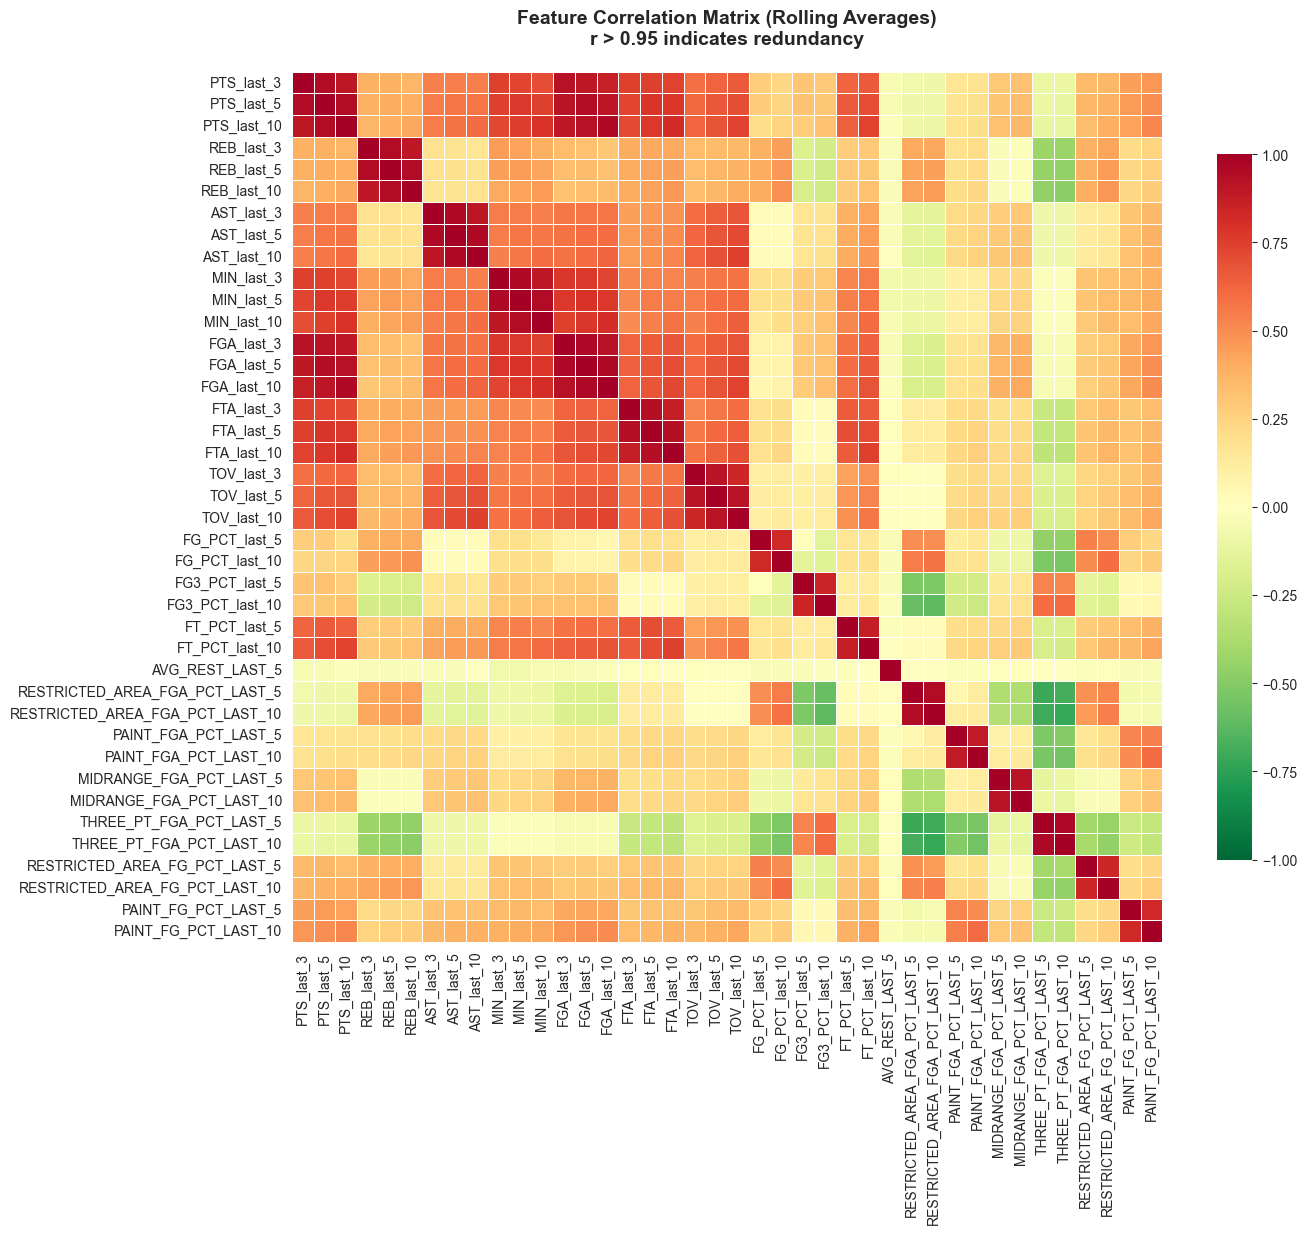

In [18]:
from scipy.stats import spearmanr

print("="*80)
print("FEATURE CORRELATION ANALYSIS - IDENTIFY REDUNDANCY")
print("="*80)

# Calculate Pearson correlation matrix
corr_matrix = X_train.corr(method='pearson')

# Find highly correlated pairs (r > 0.95)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.95:
            high_corr_pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False, key=abs)

print(f"\n🔍 Found {len(high_corr_df)} highly correlated pairs (|r| > 0.95):\n")
if len(high_corr_df) > 0:
    print(high_corr_df.head(20).to_string(index=False))
    
    # Identify which features appear most often
    all_redundant_features = list(high_corr_df['feature1']) + list(high_corr_df['feature2'])
    from collections import Counter
    feature_counts = Counter(all_redundant_features)
    
    print(f"\n\n📊 Most frequently redundant features:")
    for feat, count in feature_counts.most_common(10):
        print(f"   {feat:40s} appears in {count} pairs")
else:
    print("   No features with correlation > 0.95")

# Visualize subset of correlations (too large to show all 81x81)
print("\n📈 Creating correlation heatmap for rolling average features...")

# Select rolling average features for visualization
rolling_features = [f for f in feature_names if 'last' in f.lower()]
if len(rolling_features) > 40:
    rolling_features = rolling_features[:40]  # Limit to 40 for readability

fig, ax = plt.subplots(figsize=(14, 12))
corr_subset = X_train[rolling_features].corr()
sns.heatmap(corr_subset, annot=False, fmt='.2f', cmap='RdYlGn_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, ax=ax)
ax.set_title('Feature Correlation Matrix (Rolling Averages)\nr > 0.95 indicates redundancy', 
            fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(fig_path / 'feature_correlation_heatmap.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved to {fig_path / 'feature_correlation_heatmap.png'}")
plt.show()

FEATURE-TARGET CORRELATIONS - IDENTIFY IMPORTANCE

✅ Saved to ../results/figures/feature_target_correlations.png


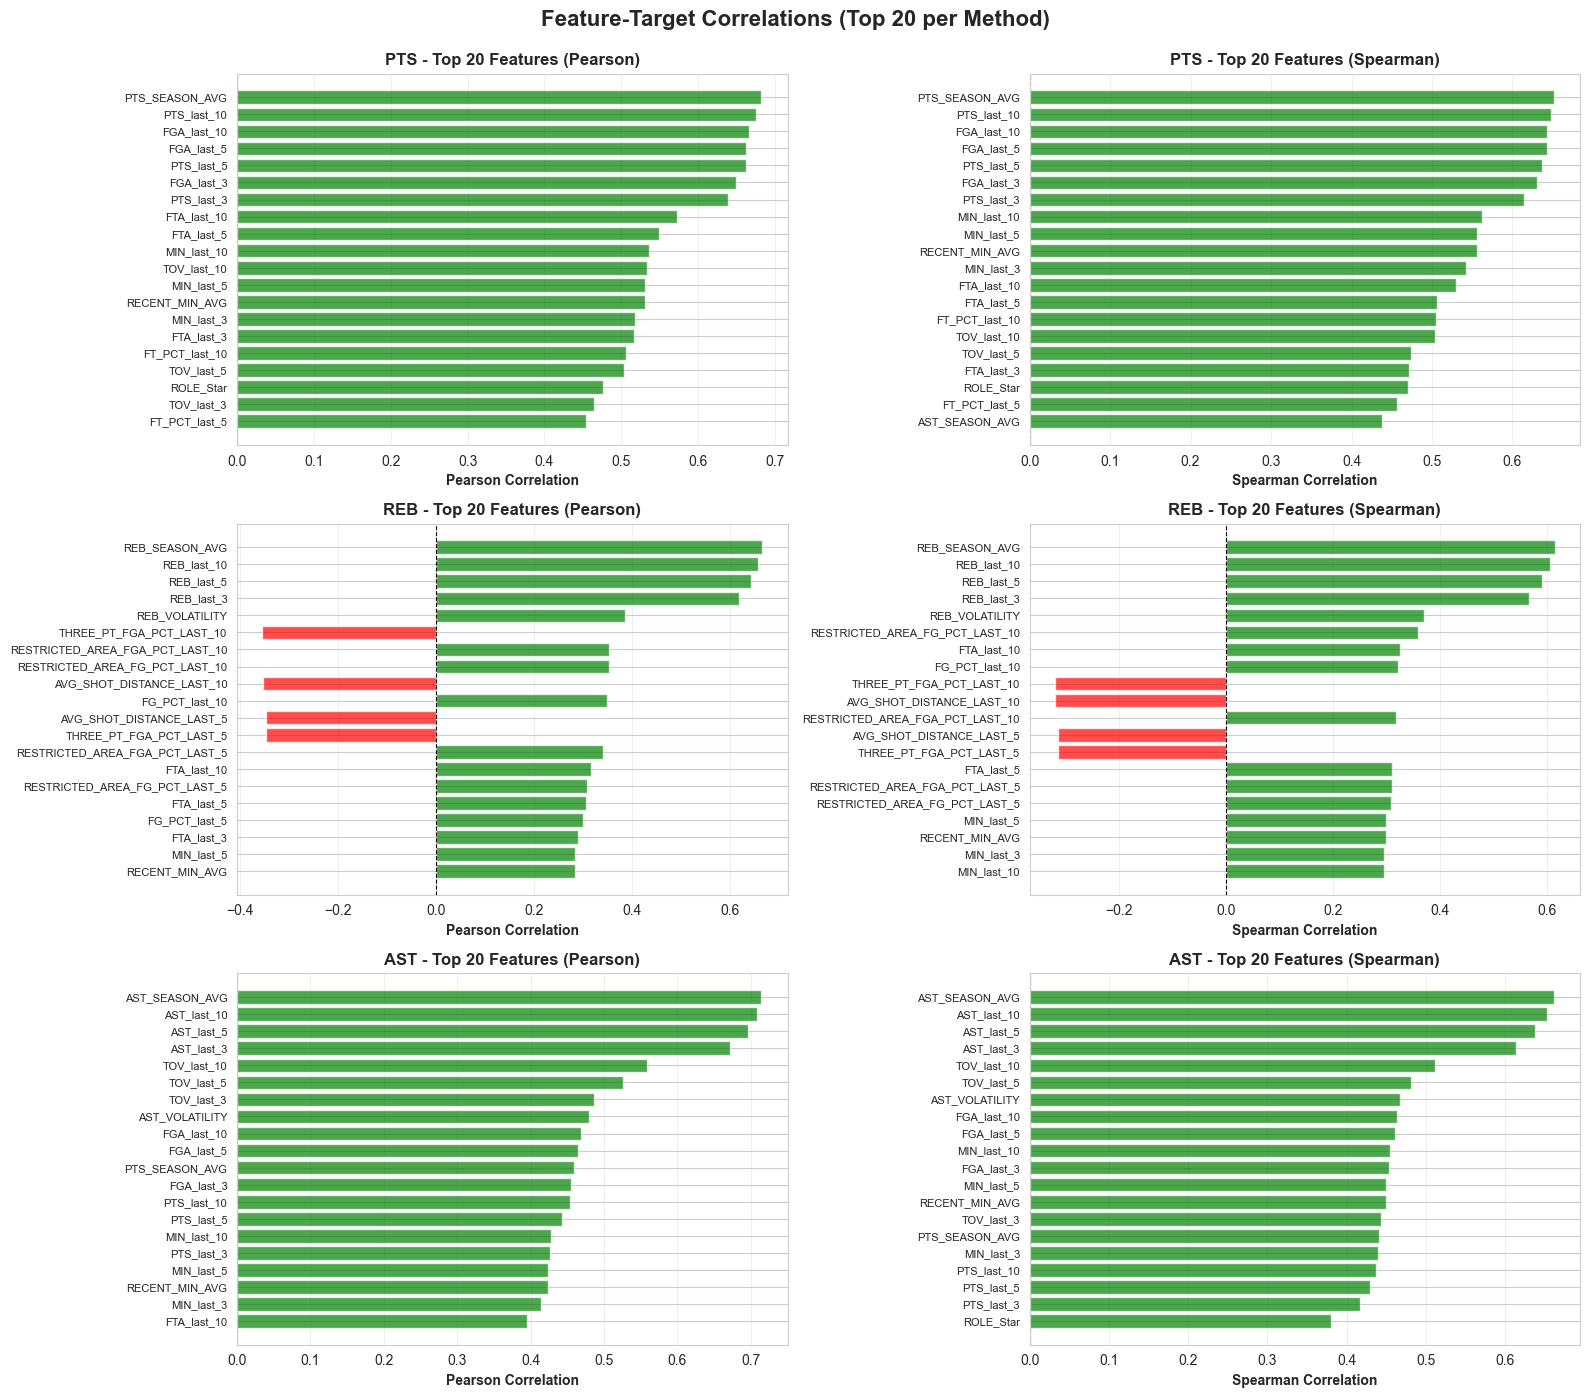


WEAK FEATURES (|correlation| < 0.05 with ALL targets)

Found 20 weak features:

            feature  max_corr  pts_corr  reb_corr  ast_corr
       BACK_TO_BACK  0.003958  0.003400 -0.003813 -0.003958
         PHASE_Late  0.006814  0.004733 -0.003622  0.006814
       DAYS_NORM_SQ  0.014251  0.014251 -0.002929  0.011913
REB_HOT_HAND_BINARY  0.015375 -0.012612 -0.015375 -0.002447
         PHASE_Peak  0.015895  0.015895  0.000216  0.014085
            IS_HOME  0.016057  0.011209  0.015578  0.016057
PTS_HOT_HAND_BINARY  0.016736 -0.016736 -0.005939 -0.011797
        PHASE_Early  0.019385 -0.019385  0.002218 -0.018943
   DAYS_INTO_SEASON  0.020615  0.020615 -0.001933  0.017281
          DAYS_NORM  0.020615  0.020615 -0.001933  0.017281
   REST_DAYS_CAPPED  0.022537 -0.022537 -0.017967 -0.011977
          REST_DAYS  0.022681 -0.022681 -0.018690 -0.012640
    AVG_REST_LAST_5  0.026344 -0.026344 -0.017433 -0.021198
          REB_TREND  0.029065  0.009534  0.029065  0.011709
AST_HOT_HAND_BINARY

In [19]:
print("="*80)
print("FEATURE-TARGET CORRELATIONS - IDENTIFY IMPORTANCE")
print("="*80)

# Calculate correlations with each target
target_correlations = {}

for target, y_data in [("PTS", y_train_pts), ("REB", y_train_reb), ("AST", y_train_ast)]:
    pearson_corr = X_train.corrwith(y_data)
    
    # Spearman for non-linear relationships
    spearman_corr = pd.Series({
        feat: spearmanr(X_train[feat], y_data)[0] 
        for feat in feature_names
    })
    
    target_correlations[target] = {
        'pearson': pearson_corr,
        'spearman': spearman_corr
    }

# Visualize top features for each target
fig, axes = plt.subplots(3, 2, figsize=(16, 14))

for idx, (target, corrs) in enumerate(target_correlations.items()):
    # Pearson (left column)
    ax_pearson = axes[idx, 0]
    top_pearson = corrs['pearson'].abs().nlargest(20).sort_values()
    colors_p = ['green' if corrs['pearson'][f] > 0 else 'red' for f in top_pearson.index]
    ax_pearson.barh(range(20), [corrs['pearson'][f] for f in top_pearson.index], color=colors_p, alpha=0.7)
    ax_pearson.set_yticks(range(20))
    ax_pearson.set_yticklabels(top_pearson.index, fontsize=8)
    ax_pearson.set_xlabel('Pearson Correlation', fontweight='bold')
    ax_pearson.set_title(f'{target} - Top 20 Features (Pearson)', fontweight='bold')
    ax_pearson.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    ax_pearson.grid(axis='x', alpha=0.3)
    
    # Spearman (right column)
    ax_spearman = axes[idx, 1]
    top_spearman = corrs['spearman'].abs().nlargest(20).sort_values()
    colors_s = ['green' if corrs['spearman'][f] > 0 else 'red' for f in top_spearman.index]
    ax_spearman.barh(range(20), [corrs['spearman'][f] for f in top_spearman.index], color=colors_s, alpha=0.7)
    ax_spearman.set_yticks(range(20))
    ax_spearman.set_yticklabels(top_spearman.index, fontsize=8)
    ax_spearman.set_xlabel('Spearman Correlation', fontweight='bold')
    ax_spearman.set_title(f'{target} - Top 20 Features (Spearman)', fontweight='bold')
    ax_spearman.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    ax_spearman.grid(axis='x', alpha=0.3)

plt.suptitle('Feature-Target Correlations (Top 20 per Method)', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(fig_path / 'feature_target_correlations.png', dpi=300, bbox_inches='tight')
print(f"\n✅ Saved to {fig_path / 'feature_target_correlations.png'}")
plt.show()

# Identify weak features (|r| < 0.05 with ALL targets)
print("\n" + "="*80)
print("WEAK FEATURES (|correlation| < 0.05 with ALL targets)")
print("="*80)

weak_features = []
for feat in feature_names:
    max_corr = max(
        abs(target_correlations['PTS']['pearson'][feat]),
        abs(target_correlations['REB']['pearson'][feat]),
        abs(target_correlations['AST']['pearson'][feat])
    )
    if max_corr < 0.05:
        weak_features.append({
            'feature': feat,
            'max_corr': max_corr,
            'pts_corr': target_correlations['PTS']['pearson'][feat],
            'reb_corr': target_correlations['REB']['pearson'][feat],
            'ast_corr': target_correlations['AST']['pearson'][feat]
        })

if len(weak_features) > 0:
    weak_df = pd.DataFrame(weak_features).sort_values('max_corr')
    print(f"\nFound {len(weak_df)} weak features:\n")
    print(weak_df.to_string(index=False))
else:
    print("\nNo features with correlation < 0.05 with all targets")

LASSO COEFFICIENT ANALYSIS - MODEL-BASED IMPORTANCE
✅ Saved to ../results/figures/lasso_coefficient_importance.png


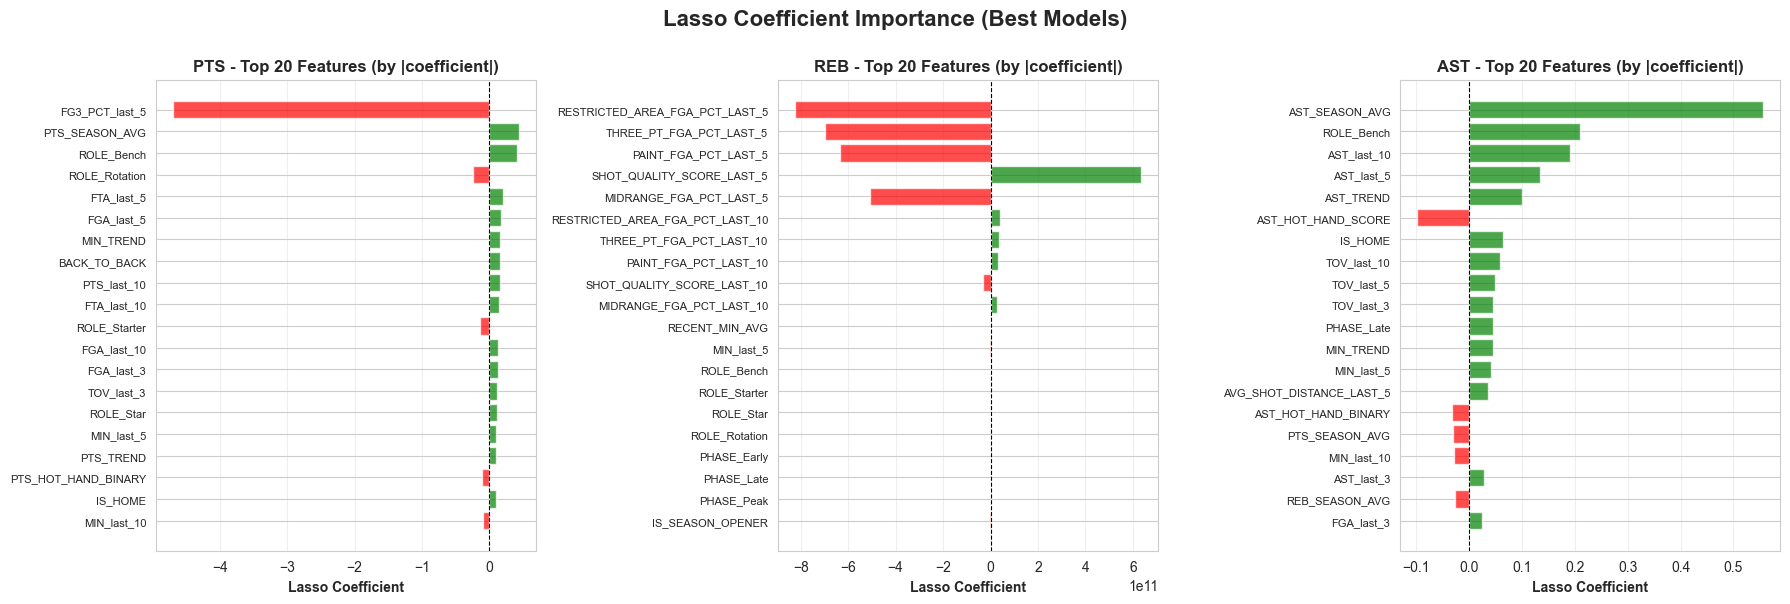


NEAR-ZERO COEFFICIENTS (|coef| < 0.01 for ALL targets)

Found 8 features with near-zero coefficients:

                                     PTS       REB       AST  max_abs_coef
RESTRICTED_AREA_FG_PCT_LAST_10  0.000741 -0.000205 -0.000235      0.000741
PAINT_FG_PCT_LAST_10            0.002172  0.000472  0.000718      0.002172
SEASON_GAME_NUM                 0.003262 -0.002765  0.001157      0.003262
AVG_REST_LAST_5                -0.005400  0.000937 -0.001717      0.005400
MIDRANGE_FG_PCT_LAST_10        -0.005676 -0.000968 -0.002402      0.005676
REST_DAYS_CAPPED               -0.000000  0.007744  0.000000      0.007744
PAINT_FG_PCT_LAST_5             0.009203  0.001830  0.000052      0.009203
RESTRICTED_AREA_FG_PCT_LAST_5   0.009818  0.002844  0.000666      0.009818


In [20]:
print("="*80)
print("LASSO COEFFICIENT ANALYSIS - MODEL-BASED IMPORTANCE")
print("="*80)

# Train best Lasso models to extract coefficients
lasso_pts = Lasso(alpha=0.01, random_state=42, max_iter=5000)
lasso_pts.fit(X_train, y_train_pts)

lasso_reb = LinearRegression()  # Best for REB was LinearRegression
lasso_reb.fit(X_train, y_train_reb)

lasso_ast = Lasso(alpha=0.001, random_state=42, max_iter=5000)
lasso_ast.fit(X_train, y_train_ast)

# Extract coefficients
coef_pts = pd.Series(lasso_pts.coef_, index=feature_names, name='PTS')
coef_reb = pd.Series(lasso_reb.coef_, index=feature_names, name='REB')
coef_ast = pd.Series(lasso_ast.coef_, index=feature_names, name='AST')

# Combine
coefficients = pd.DataFrame({
    'PTS': coef_pts,
    'REB': coef_reb,
    'AST': coef_ast
})
coefficients['max_abs_coef'] = coefficients.abs().max(axis=1)

# Visualize top coefficients
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (target, coefs) in enumerate([("PTS", coef_pts), ("REB", coef_reb), ("AST", coef_ast)]):
    ax = axes[idx]
    top_coefs = coefs.abs().nlargest(20).sort_values()
    colors = ['green' if coefs[f] > 0 else 'red' for f in top_coefs.index]
    ax.barh(range(20), [coefs[f] for f in top_coefs.index], color=colors, alpha=0.7)
    ax.set_yticks(range(20))
    ax.set_yticklabels(top_coefs.index, fontsize=8)
    ax.set_xlabel('Lasso Coefficient', fontweight='bold')
    ax.set_title(f'{target} - Top 20 Features (by |coefficient|)', fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
    ax.grid(axis='x', alpha=0.3)

plt.suptitle('Lasso Coefficient Importance (Best Models)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(fig_path / 'lasso_coefficient_importance.png', dpi=300, bbox_inches='tight')
print(f"✅ Saved to {fig_path / 'lasso_coefficient_importance.png'}")
plt.show()

# Find near-zero coefficients
print("\n" + "="*80)
print("NEAR-ZERO COEFFICIENTS (|coef| < 0.01 for ALL targets)")
print("="*80)

near_zero_coef = coefficients[coefficients['max_abs_coef'] < 0.01].copy()
near_zero_coef = near_zero_coef.sort_values('max_abs_coef')

if len(near_zero_coef) > 0:
    print(f"\nFound {len(near_zero_coef)} features with near-zero coefficients:\n")
    print(near_zero_coef.to_string())
else:
    print("\nNo features with near-zero coefficients (all have |coef| >= 0.01)")

In [21]:
print("="*80)
print("DATA-DRIVEN FEATURE SELECTION RECOMMENDATIONS")
print("="*80)

features_to_drop = []
drop_reasons = {}

# Criterion 1: Redundant features (high correlation + lower importance)
print("\n🔍 Criterion 1: Redundant Features (r > 0.95 AND lower coefficient)\n")

if len(high_corr_df) > 0:
    for _, row in high_corr_df.iterrows():
        feat1, feat2 = row['feature1'], row['feature2']
        corr_val = row['correlation']
        
        # Compare importance (use max coefficient across all targets)
        import1 = coefficients.loc[feat1, 'max_abs_coef']
        import2 = coefficients.loc[feat2, 'max_abs_coef']
        
        # Drop the less important one
        if import1 < import2:
            to_drop = feat1
            to_keep = feat2
        else:
            to_drop = feat2
            to_keep = feat1
        
        if to_drop not in features_to_drop:
            features_to_drop.append(to_drop)
            drop_reasons[to_drop] = f"Redundant with {to_keep} (r={corr_val:.3f}, coef_ratio={min(import1,import2):.4f}/{max(import1,import2):.4f})"
    
    print(f"   Identified {len([f for f in features_to_drop if 'Redundant' in drop_reasons[f]])} redundant features")
else:
    print("   No redundant features found")

# Criterion 2: Weak features (low correlation + near-zero coefficient)
print("\n🔍 Criterion 2: Weak Features (|r| < 0.05 with all targets AND |coef| < 0.01)\n")

weak_and_zero_coef = []
for feat in weak_features:
    feat_name = feat['feature']
    if coefficients.loc[feat_name, 'max_abs_coef'] < 0.01:
        if feat_name not in features_to_drop:
            features_to_drop.append(feat_name)
            drop_reasons[feat_name] = f"Weak signal (max_corr={feat['max_corr']:.4f}, max_coef={coefficients.loc[feat_name, 'max_abs_coef']:.4f})"
            weak_and_zero_coef.append(feat_name)

print(f"   Identified {len(weak_and_zero_coef)} weak features")

# Summary
print("\n" + "="*80)
print("PROPOSED FEATURES TO DROP")
print("="*80)

print(f"\n📋 Total features to drop: {len(features_to_drop)} / {len(feature_names)}")
print(f"   Resulting features: {len(feature_names) - len(features_to_drop)}\n")

if len(features_to_drop) > 0:
    drop_df = pd.DataFrame([
        {'Feature': feat, 'Reason': drop_reasons[feat]} 
        for feat in features_to_drop
    ])
    print(drop_df.to_string(index=False))
    
    # Create reduced feature list
    reduced_features = [f for f in feature_names if f not in features_to_drop]
    
    print(f"\n\n✅ Reduced feature set: {len(reduced_features)} features")
else:
    print("\nNo features meet objective drop criteria - keep all 81 features!")
    reduced_features = feature_names.copy()

DATA-DRIVEN FEATURE SELECTION RECOMMENDATIONS

🔍 Criterion 1: Redundant Features (r > 0.95 AND lower coefficient)

   Identified 15 redundant features

🔍 Criterion 2: Weak Features (|r| < 0.05 with all targets AND |coef| < 0.01)

   Identified 1 weak features

PROPOSED FEATURES TO DROP

📋 Total features to drop: 16 / 81
   Resulting features: 65

                        Feature                                                                                                 Reason
               DAYS_INTO_SEASON                                Redundant with DAYS_NORM (r=1.000, coef_ratio=50434.9340/15180914.0569)
                     MIN_last_5                      Redundant with RECENT_MIN_AVG (r=1.000, coef_ratio=695104121.1744/695104121.2295)
               REST_DAYS_CAPPED                                           Redundant with REST_DAYS (r=0.987, coef_ratio=0.0077/0.0520)
     SHOT_QUALITY_SCORE_LAST_10      Redundant with SHOT_QUALITY_SCORE_LAST_5 (r=0.983, coef_ratio=31761645580.

In [22]:
print("="*80)
print("VALIDATION: REDUCED FEATURE SET PERFORMANCE")
print("="*80)

if len(features_to_drop) > 0:
    print(f"\nTesting reduced feature set ({len(reduced_features)} features)...")
    
    # Prepare reduced feature sets
    X_train_reduced = X_train[reduced_features]
    X_val_reduced = X_val[reduced_features]
    
    # Re-train best models on reduced features
    print("\n🔄 Re-training best models on reduced features...")
    
    # PTS: Lasso(α=0.01)
    lasso_pts_reduced = Lasso(alpha=0.01, random_state=42, max_iter=5000)
    lasso_pts_reduced.fit(X_train_reduced, y_train_pts)
    pts_pred_reduced = lasso_pts_reduced.predict(X_val_reduced)
    pts_mae_reduced = mean_absolute_error(y_val_pts, pts_pred_reduced)
    
    # REB: LinearRegression
    lr_reb_reduced = LinearRegression()
    lr_reb_reduced.fit(X_train_reduced, y_train_reb)
    reb_pred_reduced = lr_reb_reduced.predict(X_val_reduced)
    reb_mae_reduced = mean_absolute_error(y_val_reb, reb_pred_reduced)
    
    # AST: Lasso(α=0.001)
    lasso_ast_reduced = Lasso(alpha=0.001, random_state=42, max_iter=5000)
    lasso_ast_reduced.fit(X_train_reduced, y_train_ast)
    ast_pred_reduced = lasso_ast_reduced.predict(X_val_reduced)
    ast_mae_reduced = mean_absolute_error(y_val_ast, ast_pred_reduced)
    
    # Compare
    print("\n" + "="*80)
    print("PERFORMANCE COMPARISON: FULL vs REDUCED FEATURES")
    print("="*80)
    
    comparison = pd.DataFrame({
        'Target': ['PTS', 'REB', 'AST'],
        'Full Features (81)': [
            results_pts.loc[results_pts['val_mae'].idxmin(), 'val_mae'],
            results_reb.loc[results_reb['val_mae'].idxmin(), 'val_mae'],
            results_ast.loc[results_ast['val_mae'].idxmin(), 'val_mae']
        ],
        f'Reduced Features ({len(reduced_features)})': [pts_mae_reduced, reb_mae_reduced, ast_mae_reduced],
        'Difference': [
            pts_mae_reduced - results_pts['val_mae'].min(),
            reb_mae_reduced - results_reb['val_mae'].min(),
            ast_mae_reduced - results_ast['val_mae'].min()
        ]
    })
    comparison['Accept?'] = comparison['Difference'].abs() < 0.02
    
    print("\n" + comparison.to_string(index=False))
    
    print("\n" + "="*80)
    
    if all(comparison['Accept?']):
        print("✅ VALIDATION PASSED: Performance maintained with reduced features!")
        print(f"   Dropped {len(features_to_drop)} features with < 0.02 MAE impact")
        
        # Save reduced feature list
        reduced_metadata = {
            'original_features': len(feature_names),
            'reduced_features': len(reduced_features),
            'dropped_features': len(features_to_drop),
            'feature_names': reduced_features,
            'dropped_feature_details': [
                {'feature': feat, 'reason': drop_reasons[feat]}
                for feat in features_to_drop
            ],
            'performance_impact': {
                'PTS': float(comparison.loc[0, 'Difference']),
                'REB': float(comparison.loc[1, 'Difference']),
                'AST': float(comparison.loc[2, 'Difference']),
            }
        }
        
        with open(Path('../data/processed/reduced_feature_names.json'), 'w') as f:
            json.dump(reduced_metadata, f, indent=2)
        
        print(f"\n📁 Saved to data/processed/reduced_feature_names.json")
    else:
        print("❌ VALIDATION FAILED: Performance degraded > 0.02 MAE")
        print("   Recommendation: Keep all 81 features for now")
        print("   Tree models (XGBoost/LightGBM) handle redundancy automatically")
else:
    print("\n✅ No features identified for removal based on objective criteria")
    print("   All 81 features contribute meaningfully to predictions")
    print("   Proceed to notebook 05 with full feature set")

print("\n" + "="*80)
print("✅ FEATURE ANALYSIS COMPLETE")
print("="*80)
print("\n📊 Summary:")
print(f"   Original features: {len(feature_names)}")
print(f"   Dropped features:  {len(features_to_drop)}")
print(f"   Final features:    {len(reduced_features)}")
print("\n➡️  Ready for Notebook 05: Advanced Models (XGBoost, LightGBM, Ensembles)")

VALIDATION: REDUCED FEATURE SET PERFORMANCE

Testing reduced feature set (65 features)...

🔄 Re-training best models on reduced features...

PERFORMANCE COMPARISON: FULL vs REDUCED FEATURES

Target  Full Features (81)  Reduced Features (65)  Difference  Accept?
   PTS            4.928312               4.929189    0.000877     True
   REB            1.965630               1.965574   -0.000057     True
   AST            1.475972               1.485360    0.009387     True

✅ VALIDATION PASSED: Performance maintained with reduced features!
   Dropped 16 features with < 0.02 MAE impact

📁 Saved to data/processed/reduced_feature_names.json

✅ FEATURE ANALYSIS COMPLETE

📊 Summary:
   Original features: 81
   Dropped features:  16
   Final features:    65

➡️  Ready for Notebook 05: Advanced Models (XGBoost, LightGBM, Ensembles)
